# Import package

In [1]:
from datetime import datetime
import lightgbm as lgb
from lightgbm import LGBMClassifier
from lightgbm import plot_importance
import matplotlib.pyplot as plt
from matplotlib import pyplot
from matplotlib.pyplot import MultipleLocator
%matplotlib inline
import numpy as np
from numpy import mean
from numpy import std
from numpy import sort
import pandas as pd
from pandas.core.frame import DataFrame
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics
from sklearn.metrics import f1_score  
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import confusion_matrix,roc_curve,roc_auc_score,accuracy_score, plot_confusion_matrix,classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight
from sklearn.metrics import log_loss
import seaborn as sns
from time import time
import pprint
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import make_scorer
from skopt import BayesSearchCV
from skopt.callbacks import DeadlineStopper,DeltaYStopper
from skopt.space import Real,Categorical,Integer
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import RFE
import joblib
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

# Dataset

## Original dataset

In [2]:
CTGData=pd.read_csv('CTG.csv')

In [3]:
CTGData3=CTGData.copy()
X=CTGData3.drop(labels=['CLASS','NSP'],axis=1)

y=CTGData3['CLASS'].values

In [4]:
#stanardilization
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
scaler.fit(X)
X=scaler.transform(X)

In [5]:
#split train dataset and test dataset
X_train, X_test,y_train,y_test= train_test_split(X,y,test_size=0.2,random_state=42)



## Selected feature

In [6]:
features20=pd.read_csv('CTGPattern selected 20 features.csv')
# ,index_col=0)
features20.head()

,LB,AC,FM,UC,DL,DP,ASTV,MSTV,ALTV,MLTV,...,Min,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency,label
0,120,0.000000,0.0,0.000000,0.000000,0.0,73,0.5,43,2.4,...,62,126,2,0,120,137,121,73,1,8
1,132,0.006380,0.0,0.006380,0.003190,0.0,17,2.1,0,10.4,...,68,198,6,1,141,136,140,12,0,5
2,133,0.003322,0.0,0.008306,0.003322,0.0,16,2.1,0,13.4,...,68,198,5,1,141,135,138,13,0,5
3,134,0.002561,0.0,0.007682,0.002561,0.0,16,2.4,0,23.0,...,53,170,11,0,137,134,137,13,1,5
4,132,0.006515,0.0,0.008143,0.000000,0.0,16,2.4,0,19.9,...,53,170,9,0,137,136,138,11,1,1


In [7]:
X1=features20.drop(labels=['label'],axis=1)

y1=features20['label'].values

In [8]:
scaler=StandardScaler()
scaler.fit(X1)
X1=scaler.transform(X1)
#split train dataset and test dataset
X1_train, X1_test,y1_train,y1_test= train_test_split(X1,y1,test_size=0.2, shuffle = True,stratify=y1,random_state=42)

# Models

## Light GBM

In [9]:
lgbm1=LGBMClassifier(boosting_type='gbdt',objective ='multiclass',
                                 max_depth=8, num_leaves=170,
                                learning_rate=0.01,n_estimators=300,
                                colsample_bytree= 0.7101,subsample= 0.5)

In [10]:
start=datetime.now()
lgbm1.fit(X1_train,y1_train)
stop=datetime.now()
execution_time_lgbm40='%.4f'%(stop-start).total_seconds()
execution_time_lgbm40



'2.5070'

In [11]:

lgbm_ctgpatt=lgbm1.fit(X1_train,y1_train)

In [12]:
y_pred_lgbm1=lgbm1.predict((X1_test))
y_prob_lgbm1=lgbm1.predict_proba((X1_test))
print("Accuracy score with LGBM is: ",accuracy_score(y1_test, y_pred_lgbm1))
print("F1 score with LGBM is: ",f1_score(y1_test, y_pred_lgbm1,average='micro'))
print("ROC_AUC score with LGBM is: ", roc_auc_score(y1_test,y_prob_lgbm1,multi_class='ovr',labels=np.unique(y1_test)))
print("Cross entropy loss score with LGBM is: ",log_loss(y1_test,y_prob_lgbm1))


Accuracy score with LGBM is:  0.8873239436619719
F1 score with LGBM is:  0.8873239436619719
ROC_AUC score with LGBM is:  0.9880809383796739
Cross entropy loss score with LGBM is:  0.3604962851482299


In [13]:
lgbm_accuracy='%.4f'%accuracy_score(y1_test, y_pred_lgbm1)
lgbm_f1='%.4f'%f1_score(y1_test, y_pred_lgbm1,average='micro')
lgbm_roc_auc='%.4f'% roc_auc_score(y1_test,y_prob_lgbm1,multi_class='ovr',labels=np.unique(y1_test))
lgbm_loss='%.4f'%log_loss(y1_test,y_prob_lgbm1)
print(lgbm_accuracy)
print(lgbm_f1)
print(lgbm_roc_auc)
print(lgbm_loss)

0.8873
0.8873
0.9881
0.3605


In [14]:
start=datetime.now()
accuracy_score_20 =cross_val_score(lgbm1, X1_train, y1_train, cv=5,scoring='accuracy').mean()
F1_score_20 =cross_val_score(lgbm1, X1_train, y1_train, cv=5,scoring='f1_micro').mean()
roc_auc_score_20 =cross_val_score(lgbm1, X1_train, y1_train, cv=5,scoring='roc_auc_ovr').mean()
neg_loss_score_20 =cross_val_score(lgbm1, X1_train, y1_train, cv=5,scoring='neg_log_loss').mean()
stop=datetime.now()

execution_time_lgbm4=(stop-start)/20
execution_time_lgbm4

print("accuracy 20  feature:",accuracy_score_20)
print('F1 score 20  feature:',F1_score_20)
print('roc_auc 20  feature:',roc_auc_score_20)
print("cross entropy loss 20  feature:",neg_loss_score_20)


accuracy 20  feature: 0.8788235294117648
F1 score 20  feature: 0.8788235294117648
roc_auc 20  feature: 0.9887342339045496
cross entropy loss 20  feature: -0.39853620080072305


In [15]:
training_time_lgbm=execution_time_lgbm4.total_seconds()
training_time_lgbm='%.4f'%training_time_lgbm
print(training_time_lgbm)

2.1351


In [16]:
# save the model
joblib.dump(lgbm_ctgpatt,'lgbm_ctgpatt.model')

['lgbm_ctgpatt.model']

In [17]:
rflgbm_CTGPATT=joblib.load('lgbm_ctgpatt.model')
   #应用模型进行预测
resultlgmb=rflgbm_CTGPATT.score(X1_test,y1_test)

In [18]:
resultlgmb

0.8873239436619719

## SVM 

In [19]:
svc = SVC(random_state=42
           ,C= 8.5385
           ,kernel='rbf'
           ,degree= 7
          ,gamma="scale"
          , probability=True)
accuracies = cross_val_score(svc,X1_train,y1_train,cv=5)
svc.fit(X1_train,y1_train)
svc.predict(X1_test)
print("Train Score:",np.mean(accuracies))
print("Test Score:",svc.score(X1_test,y1_test))

Train Score: 0.8158823529411766
Test Score: 0.8661971830985915


In [20]:
start=datetime.now()
accuracy_score_20_svm =cross_val_score(svc, X1_train, y1_train, cv=5,scoring='accuracy').mean()
F1_score_20_svm =cross_val_score(svc, X1_train, y1_train, cv=5,scoring='f1_micro').mean()
roc_auc_score_20_svm =cross_val_score(svc, X1_train, y1_train, cv=5,scoring='roc_auc_ovr').mean()
neg_loss_score_20_svm =cross_val_score(svc, X1_train, y1_train, cv=5,scoring='neg_log_loss').mean()

stop=datetime.now()
execution_time_svm=(stop-start)/20
execution_time_svm

print("accuracy 20  feature:",accuracy_score_20_svm)
print('F1 score 20  feature:',F1_score_20_svm)
print('roc_auc 20  feature:',roc_auc_score_20_svm)
print("cross entropy loss 20  feature:",neg_loss_score_20_svm)

accuracy 20  feature: 0.8158823529411766
F1 score 20  feature: 0.8158823529411764
roc_auc 20  feature: 0.9835349962317622
cross entropy loss 20  feature: -0.48419110486469885


In [21]:
training_time_svm=execution_time_svm.total_seconds()
training_time_svm='%.4f'%training_time_svm
print(training_time_svm)

0.3817


In [22]:
svc_ctgpatt=svc.fit( X1_train, y1_train)

In [23]:
y_pred_svc=svc.predict(X1_test)
y_prob_svc=svc.predict_proba(X1_test)

In [24]:

svc_accuracy='%.4f'%accuracy_score(y1_test, y_pred_svc)
svc_f1='%.4f'%f1_score(y1_test, y_pred_svc,average='micro')
svc_roc_auc='%.4f'% roc_auc_score(y1_test,y_prob_svc,multi_class='ovr',labels=np.unique(y1_test))
svc_loss='%.4f'%log_loss(y1_test,y_prob_svc)
print(svc_accuracy)
print(svc_f1)
print(svc_roc_auc)
print(svc_loss)

0.8662
0.8662
0.9873
0.3815


In [25]:
  #保存模型
joblib.dump(svc_ctgpatt,'svc_ctgpatt.model')

['svc_ctgpatt.model']

In [26]:
#加载模型
RFsvc=joblib.load('svc_ctgpatt.model')
   #应用模型进行预测
resultsvc=RFsvc.score(X1_test,y1_test)

In [27]:
resultsvc

0.8661971830985915

## Random Forest

In [28]:
rf2=RFC(random_state=0, max_features='auto', n_estimators= 100, max_depth=11, criterion='entropy')
rf2.fit(X1_train, y1_train)

RandomForestClassifier(criterion='entropy', max_depth=11, random_state=0)

In [29]:
# rf2= RFC(random_state=42, max_features='auto', n_estimators= 150,
#                                      max_depth=13, 
#                                      criterion='gini')


In [30]:
start=datetime.now()
accuracy_score_10_rf =cross_val_score(rf2, X1_train, y1_train, cv=5,scoring='accuracy').mean()
F1_score_10_rf =cross_val_score(rf2, X1_train, y1_train, cv=5,scoring='f1_micro').mean()
roc_auc_score_10_rf =cross_val_score(rf2, X1_train, y1_train, cv=5,scoring='roc_auc_ovr').mean()
neg_loss_score_10_rf =cross_val_score(rf2, X1_train, y1_train, cv=5,scoring='neg_log_loss').mean()

stop=datetime.now()
execution_time_rf=(stop-start)/20
execution_time_rf

print("accuracy 10  feature:",accuracy_score_10_rf)
print('F1 score 10  feature:',F1_score_10_rf)
print('roc_auc 10  feature:',roc_auc_score_10_rf)
print("cross entropy loss 10  feature:",neg_loss_score_10_rf)

accuracy 10  feature: 0.858235294117647
F1 score 10  feature: 0.858235294117647
roc_auc 10  feature: 0.9883670353707379
cross entropy loss 10  feature: -0.46429756384947984


In [31]:
training_time_rf=execution_time_rf.total_seconds()
training_time_rf='%.4f'%training_time_rf
print(training_time_rf)

0.3890


In [32]:
rf_ctgpatt=rf2.fit(X1_train,y1_train)
y_pred_rf2=rf2.predict(X1_test)
y_prob_rf2=rf2.predict_proba(X1_test)
print("Accuracy score with LGBM is: ",accuracy_score(y1_test, y_pred_rf2))
print("F1 score with LGBM is: ",f1_score(y1_test, y_pred_rf2,average='micro'))
print("ROC_AUC score with LGBM is: ", roc_auc_score(y1_test,y_prob_rf2,multi_class='ovr',labels=np.unique(y1_test)))
print("Cross entropy loss score with LGBM is: ",log_loss(y1_test,y_prob_rf2))


rf_accuracy='%.4f'%accuracy_score(y1_test, y_pred_rf2)
rf_f1='%.4f'%f1_score(y1_test, y_pred_rf2,average='micro')
rf_roc_auc='%.4f'% roc_auc_score(y1_test,y_prob_rf2,multi_class='ovr',labels=np.unique(y1_test))
rf_loss='%.4f'%log_loss(y1_test,y_prob_rf2)
print(rf_accuracy)
print(rf_f1)
print(rf_roc_auc)
print(rf_loss)

Accuracy score with LGBM is:  0.8732394366197183
F1 score with LGBM is:  0.8732394366197183
ROC_AUC score with LGBM is:  0.9863248993133716
Cross entropy loss score with LGBM is:  0.4547162716782668
0.8732
0.8732
0.9863
0.4547


In [33]:
# save the model
joblib.dump(rf_ctgpatt,'rf_ctgpatt.model')

['rf_ctgpatt.model']

In [34]:
RFrf=joblib.load('rf_ctgpatt.model')

rfresult=RFrf.score(X1_test,y1_test)

In [35]:
rfresult

0.8732394366197183

## Neural Network

In [36]:

X1_train = torch.from_numpy(X1_train)
y1_train = torch.from_numpy(y1_train ).type(torch.LongTensor)

X1_test  = torch.from_numpy(X1_test )
y1_test= torch.from_numpy(y1_test).type(torch.LongTensor)


batch_size = 128

train = torch.utils.data.TensorDataset(X1_train, y1_train )
test = torch.utils.data.TensorDataset(X1_test , y1_test)

train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=True)

In [37]:
epochs =30

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
input_dim = X1.shape[1]
hidden_dim1 = 118 #hidden layer1
hidden_dim2 = 79 #hidden layer2 
output_dim = len(set(y1))

In [38]:
class ANNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim1,hidden_dim2, output_dim):
        super(ANNModel, self).__init__()

        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.relu1 = nn.ReLU() 
        
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.relu2 = nn.ReLU()
        
        self.fc3 = nn.Linear(hidden_dim2, output_dim)
        
        
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        return out

In [39]:
model = ANNModel(input_dim, hidden_dim1,hidden_dim2,output_dim)


learning_rate = 0.0175
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
criterion = nn.CrossEntropyLoss()


In [40]:
start=datetime.now()

total_step = len(train_loader)
model.train()
for epoch in range(epochs):
    tot_loss = 0.0
    tot_acc = 0.0
    train_preds = []
    train_trues = []
  # model.train()
    for i,(train_data_batch, train_label_batch) in enumerate(train_loader):
        train_data_batch = train_data_batch.float().to(device) # 将double数据转换为float
        train_label_batch = train_label_batch.to(device)
        outputs = model(train_data_batch)
        # _, preds = torch.max(outputs.data, 1)
        loss = criterion(outputs, train_label_batch)
        # print(loss)
  
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
  
        tot_loss += loss.data
        train_outputs = outputs.argmax(dim=1)
        train_preds.extend(train_outputs.detach().cpu().numpy())
        train_trues.extend(train_label_batch.detach().cpu().numpy())
        # tot_acc += (outputs.argmax(dim=1) == train_label_batch).sum().item()
        sklearn_accuracy = accuracy_score(train_trues, train_preds)
        sklearn_precision = precision_score(train_trues, train_preds, average='micro')
        sklearn_recall = recall_score(train_trues, train_preds, average='micro')
        sklearn_f1 = f1_score(train_trues, train_preds, average='micro')
        print("[sklearn_metrics] Epoch:{} loss:{:.4f} accuracy:{:.4f} precision:{:.4f} recall:{:.4f} f1:{:.4f}".format(epoch, tot_loss, sklearn_accuracy, sklearn_precision, sklearn_recall, sklearn_f1))
stop=datetime.now()
execution_time_ann=(stop-start)
execution_time_ann='%.4f'%(execution_time_ann).total_seconds()
print('execution_time_ann',execution_time_ann)
test_preds = []
test_trues = []
model.eval()
with torch.no_grad():
    for i,(test_data_batch, test_data_label) in enumerate(test_loader):
        test_data_batch = test_data_batch.float().to(device) # 将double数据转换为float
        test_data_label = test_data_label.to(device)
        test_outputs = model(test_data_batch)
        
        probs = F.softmax(test_outputs, dim=1)
        test_outputs = test_outputs.argmax(dim=1)
        testloss = criterion(probs, test_data_label)
#         preds = torch.argmax(logits, dim=1)
        test_preds.extend(test_outputs.detach().cpu().numpy())
        test_trues.extend(test_data_label.detach().cpu().numpy())
        sklearn_accuracy = accuracy_score(test_trues, test_preds)
        sklearn_precision = precision_score(test_trues, test_preds, average='micro')
        sklearn_recall = recall_score(test_trues, test_preds, average='micro')
        sklearn_f1 = f1_score(test_trues, test_preds, average='micro')
#         print("Loss score is: ", log_loss(test_data_label,probs))
        print(classification_report(test_trues, test_preds))
        conf_matrix = confusion_matrix(test_trues, test_preds)
        print(conf_matrix)
#         plot_confusion_matrix(conf_matrix)
        print("[sklearn_metrics] accuracy:{:.4f} precision:{:.4f} recall:{:.4f} f1:{:.4f}".format(sklearn_accuracy, sklearn_precision, sklearn_recall, sklearn_f1))

[sklearn_metrics] Epoch:0 loss:2.3608 accuracy:0.0625 precision:0.0625 recall:0.0625 f1:0.0625
[sklearn_metrics] Epoch:0 loss:4.3087 accuracy:0.2656 precision:0.2656 recall:0.2656 f1:0.2656
[sklearn_metrics] Epoch:0 loss:6.1365 accuracy:0.3281 precision:0.3281 recall:0.3281 f1:0.3281
[sklearn_metrics] Epoch:0 loss:7.7437 accuracy:0.3691 precision:0.3691 recall:0.3691 f1:0.3691
[sklearn_metrics] Epoch:0 loss:9.1449 accuracy:0.4000 precision:0.4000 recall:0.4000 f1:0.4000
[sklearn_metrics] Epoch:0 loss:10.3246 accuracy:0.4375 precision:0.4375 recall:0.4375 f1:0.4375
[sklearn_metrics] Epoch:0 loss:11.4355 accuracy:0.4621 precision:0.4621 recall:0.4621 f1:0.4621
[sklearn_metrics] Epoch:0 loss:12.4919 accuracy:0.4766 precision:0.4766 recall:0.4766 f1:0.4766
[sklearn_metrics] Epoch:0 loss:13.4490 accuracy:0.4957 precision:0.4957 recall:0.4957 f1:0.4957
[sklearn_metrics] Epoch:0 loss:14.3564 accuracy:0.5047 precision:0.5047 recall:0.5047 f1:0.5047
[sklearn_metrics] Epoch:0 loss:15.1957 accura

[sklearn_metrics] Epoch:7 loss:2.8497 accuracy:0.8404 precision:0.8404 recall:0.8404 f1:0.8404
[sklearn_metrics] Epoch:7 loss:3.3218 accuracy:0.8340 precision:0.8340 recall:0.8340 f1:0.8340
[sklearn_metrics] Epoch:7 loss:3.6664 accuracy:0.8342 precision:0.8342 recall:0.8342 f1:0.8342
[sklearn_metrics] Epoch:7 loss:4.1061 accuracy:0.8336 precision:0.8336 recall:0.8336 f1:0.8336
[sklearn_metrics] Epoch:7 loss:4.6572 accuracy:0.8288 precision:0.8288 recall:0.8288 f1:0.8288
[sklearn_metrics] Epoch:7 loss:5.0515 accuracy:0.8314 precision:0.8314 recall:0.8314 f1:0.8314
[sklearn_metrics] Epoch:7 loss:5.3708 accuracy:0.8329 precision:0.8329 recall:0.8329 f1:0.8329
[sklearn_metrics] Epoch:7 loss:5.7035 accuracy:0.8324 precision:0.8324 recall:0.8324 f1:0.8324
[sklearn_metrics] Epoch:8 loss:0.4175 accuracy:0.8438 precision:0.8438 recall:0.8438 f1:0.8438
[sklearn_metrics] Epoch:8 loss:0.9949 accuracy:0.8398 precision:0.8398 recall:0.8398 f1:0.8398
[sklearn_metrics] Epoch:8 loss:1.4244 accuracy:0.8

[sklearn_metrics] Epoch:14 loss:1.5292 accuracy:0.9049 precision:0.9049 recall:0.9049 f1:0.9049
[sklearn_metrics] Epoch:14 loss:1.7484 accuracy:0.9074 precision:0.9074 recall:0.9074 f1:0.9074
[sklearn_metrics] Epoch:14 loss:2.0732 accuracy:0.9033 precision:0.9033 recall:0.9033 f1:0.9033
[sklearn_metrics] Epoch:14 loss:2.5269 accuracy:0.8950 precision:0.8950 recall:0.8950 f1:0.8950
[sklearn_metrics] Epoch:14 loss:2.7442 accuracy:0.8969 precision:0.8969 recall:0.8969 f1:0.8969
[sklearn_metrics] Epoch:14 loss:3.0513 accuracy:0.8963 precision:0.8963 recall:0.8963 f1:0.8963
[sklearn_metrics] Epoch:14 loss:3.3099 accuracy:0.8952 precision:0.8952 recall:0.8952 f1:0.8952
[sklearn_metrics] Epoch:14 loss:3.5763 accuracy:0.8972 precision:0.8972 recall:0.8972 f1:0.8972
[sklearn_metrics] Epoch:14 loss:3.8197 accuracy:0.8988 precision:0.8988 recall:0.8988 f1:0.8988
[sklearn_metrics] Epoch:15 loss:0.2214 accuracy:0.9062 precision:0.9062 recall:0.9062 f1:0.9062
[sklearn_metrics] Epoch:15 loss:0.3472 a

[sklearn_metrics] Epoch:21 loss:1.3830 accuracy:0.9336 precision:0.9336 recall:0.9336 f1:0.9336
[sklearn_metrics] Epoch:21 loss:1.5913 accuracy:0.9332 precision:0.9332 recall:0.9332 f1:0.9332
[sklearn_metrics] Epoch:21 loss:1.8524 accuracy:0.9289 precision:0.9289 recall:0.9289 f1:0.9289
[sklearn_metrics] Epoch:21 loss:1.9719 accuracy:0.9304 precision:0.9304 recall:0.9304 f1:0.9304
[sklearn_metrics] Epoch:21 loss:2.1144 accuracy:0.9323 precision:0.9323 recall:0.9323 f1:0.9323
[sklearn_metrics] Epoch:21 loss:2.2560 accuracy:0.9321 precision:0.9321 recall:0.9321 f1:0.9321
[sklearn_metrics] Epoch:21 loss:2.3617 accuracy:0.9324 precision:0.9324 recall:0.9324 f1:0.9324
[sklearn_metrics] Epoch:22 loss:0.1531 accuracy:0.9531 precision:0.9531 recall:0.9531 f1:0.9531
[sklearn_metrics] Epoch:22 loss:0.2949 accuracy:0.9336 precision:0.9336 recall:0.9336 f1:0.9336
[sklearn_metrics] Epoch:22 loss:0.3923 accuracy:0.9479 precision:0.9479 recall:0.9479 f1:0.9479
[sklearn_metrics] Epoch:22 loss:0.5970 a

[sklearn_metrics] Epoch:28 loss:2.3578 accuracy:0.9353 precision:0.9353 recall:0.9353 f1:0.9353
[sklearn_metrics] Epoch:29 loss:0.1297 accuracy:0.9297 precision:0.9297 recall:0.9297 f1:0.9297
[sklearn_metrics] Epoch:29 loss:0.2943 accuracy:0.9297 precision:0.9297 recall:0.9297 f1:0.9297
[sklearn_metrics] Epoch:29 loss:0.3736 accuracy:0.9479 precision:0.9479 recall:0.9479 f1:0.9479
[sklearn_metrics] Epoch:29 loss:0.4910 accuracy:0.9473 precision:0.9473 recall:0.9473 f1:0.9473
[sklearn_metrics] Epoch:29 loss:0.6182 accuracy:0.9469 precision:0.9469 recall:0.9469 f1:0.9469
[sklearn_metrics] Epoch:29 loss:0.7283 accuracy:0.9479 precision:0.9479 recall:0.9479 f1:0.9479
[sklearn_metrics] Epoch:29 loss:0.8542 accuracy:0.9487 precision:0.9487 recall:0.9487 f1:0.9487
[sklearn_metrics] Epoch:29 loss:1.1180 accuracy:0.9443 precision:0.9443 recall:0.9443 f1:0.9443
[sklearn_metrics] Epoch:29 loss:1.3098 accuracy:0.9427 precision:0.9427 recall:0.9427 f1:0.9427
[sklearn_metrics] Epoch:29 loss:1.4226 a

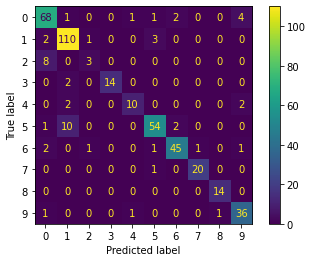

In [41]:
ConfusionMatrixDisplay.from_predictions(test_trues, test_preds)

plt.show()

In [42]:
print(classification_report(test_trues, test_preds,zero_division=1))

              precision    recall  f1-score   support

           0       0.83      0.88      0.86        77
           1       0.88      0.95      0.91       116
           2       0.60      0.27      0.37        11
           3       1.00      0.88      0.93        16
           4       0.83      0.71      0.77        14
           5       0.90      0.81      0.85        67
           6       0.92      0.88      0.90        51
           7       0.95      0.95      0.95        21
           8       0.93      1.00      0.97        14
           9       0.84      0.92      0.88        39

    accuracy                           0.88       426
   macro avg       0.87      0.83      0.84       426
weighted avg       0.88      0.88      0.87       426



In [43]:
testloss

tensor(1.6468)

In [44]:
print(accuracy_score(test_trues, test_preds))

0.8779342723004695


In [45]:
execution_time_ann

'3.2025'

In [46]:
ann_accuracy='%.4f'% accuracy_score(test_trues, test_preds)

In [47]:
ann_f1='%.4f'% f1_score(test_trues, test_preds, average='micro')

In [48]:
ann_roc_auc='%.4f'%roc_auc_score(test_data_label,probs,multi_class='ovo',labels=[0, 1,2, 3, 4, 5, 6, 7,8,9])

In [49]:
ann_loss='%.4f'% log_loss(test_data_label,probs,labels=[0, 1,2, 3, 4, 5, 6, 7,8,9])

In [50]:
ann_loss

'0.6950'

In [51]:
CTGPATTdict = { 
              'accuracy':[lgbm_accuracy,svc_accuracy,rf_accuracy,ann_accuracy],
               'f1_score': [lgbm_f1,svc_f1,rf_f1,ann_f1],
               'roc_auc': [lgbm_roc_auc,svc_roc_auc,rf_roc_auc,ann_roc_auc],
               'cross_entropy_loss': [lgbm_loss,svc_loss,rf_loss,ann_loss],
                'training_time[s]':[training_time_lgbm,training_time_svm,training_time_rf,execution_time_ann]
               }
pr_df_ctgpattern = pd.DataFrame(CTGPATTdict,index=['Light GBM','SVM','Random Forest','PyTorch ANN'])
pr_df_ctgpattern

,accuracy,f1_score,roc_auc,cross_entropy_loss,training_time[s]
Light GBM,0.8873,0.8873,0.9881,0.3605,2.1351
SVM,0.8662,0.8662,0.9873,0.3815,0.3817
Random Forest,0.8732,0.8732,0.9863,0.4547,0.3890
PyTorch ANN,0.8779,0.8779,0.9807,0.6950,3.2025


In [52]:
pr_df_ctgpattern.to_csv('CTGPattern Score.csv')